# Машинное обучение, ФКН ВШЭ

# Практическое задание 11. Несбалансированные задачи

## Общая информация
Дата выдачи: 23.04.2024

Мягкий дедлайн: 13.05.2024 23:59 MSK

Жесткий дедлайн: 18.05.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from tqdm.auto import tqdm

**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [4]:
#your code here
df['Class'].value_counts()[1]/(len(df))

0.001727485630620034

Чуть больше чем 17 сотых процента

Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [5]:
#your code here
df['day'] = df['Time']//(60*60*24)
df['hour'] = (df['Time'] - df['day']*(60*60*24))//(60*60)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,day,hour
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.0,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,1.0,23.0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,1.0,23.0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,1.0,23.0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,1.0,23.0


In [6]:
df['Time'].max()/(60*60*24)

1.9999074074074075

Данные покрывают почти 2 дня

Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

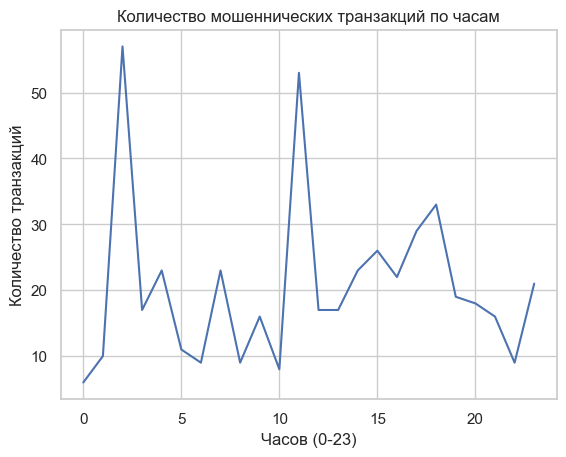

In [7]:
class_1_df = df.loc[df['Class'] == 1]

hourly_counts = class_1_df['hour'].value_counts().sort_index()
hourly_counts_df = hourly_counts.reset_index()
hourly_counts_df.columns = ['hour', 'transactions']

# Создаем график с помощью seaborn
sns.lineplot(data=hourly_counts_df, x='hour', y='transactions')
plt.title('Количество мошеннических транзакций по часам')
plt.xlabel('Часов (0-23)')
plt.ylabel('Количество транзакций')
plt.show()

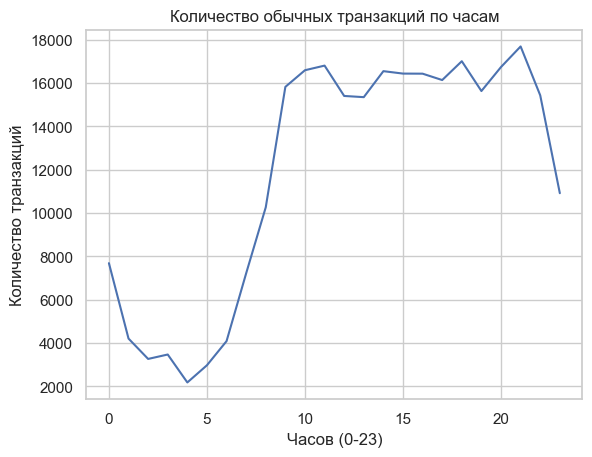

In [8]:
class_0_df = df.loc[df['Class'] == 0]

hourly_counts = class_0_df['hour'].value_counts().sort_index()
hourly_counts_df = hourly_counts.reset_index()
hourly_counts_df.columns = ['hour', 'transactions']

# Создаем график с помощью seaborn
sns.lineplot(data=hourly_counts_df, x='hour', y='transactions')
plt.title('Количество обычных транзакций по часам')
plt.xlabel('Часов (0-23)')
plt.ylabel('Количество транзакций')
plt.show()

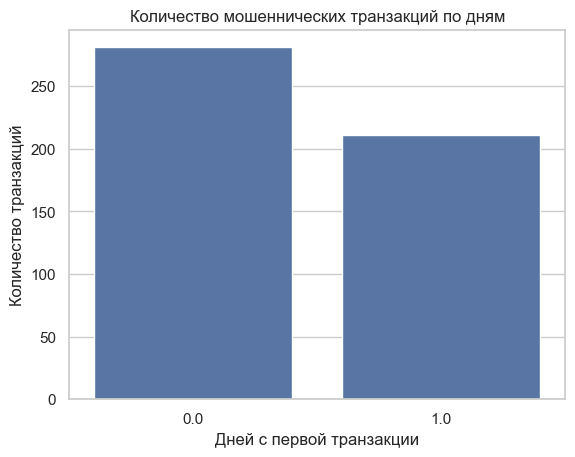

In [9]:
class_1_df = df.loc[df['Class'] == 1]

hourly_counts = class_1_df['day'].value_counts().sort_index()
hourly_counts_df = hourly_counts.reset_index()
hourly_counts_df.columns = ['day', 'transactions']

# Создаем график с помощью seaborn
sns.barplot(data=hourly_counts_df, x='day', y='transactions')
plt.title('Количество мошеннических транзакций по дням')
plt.xlabel('Дней с первой транзакции')
plt.ylabel('Количество транзакций')
plt.show()

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

In [10]:
#your code here
krut = df.corr()['Class'].nlargest(6).index

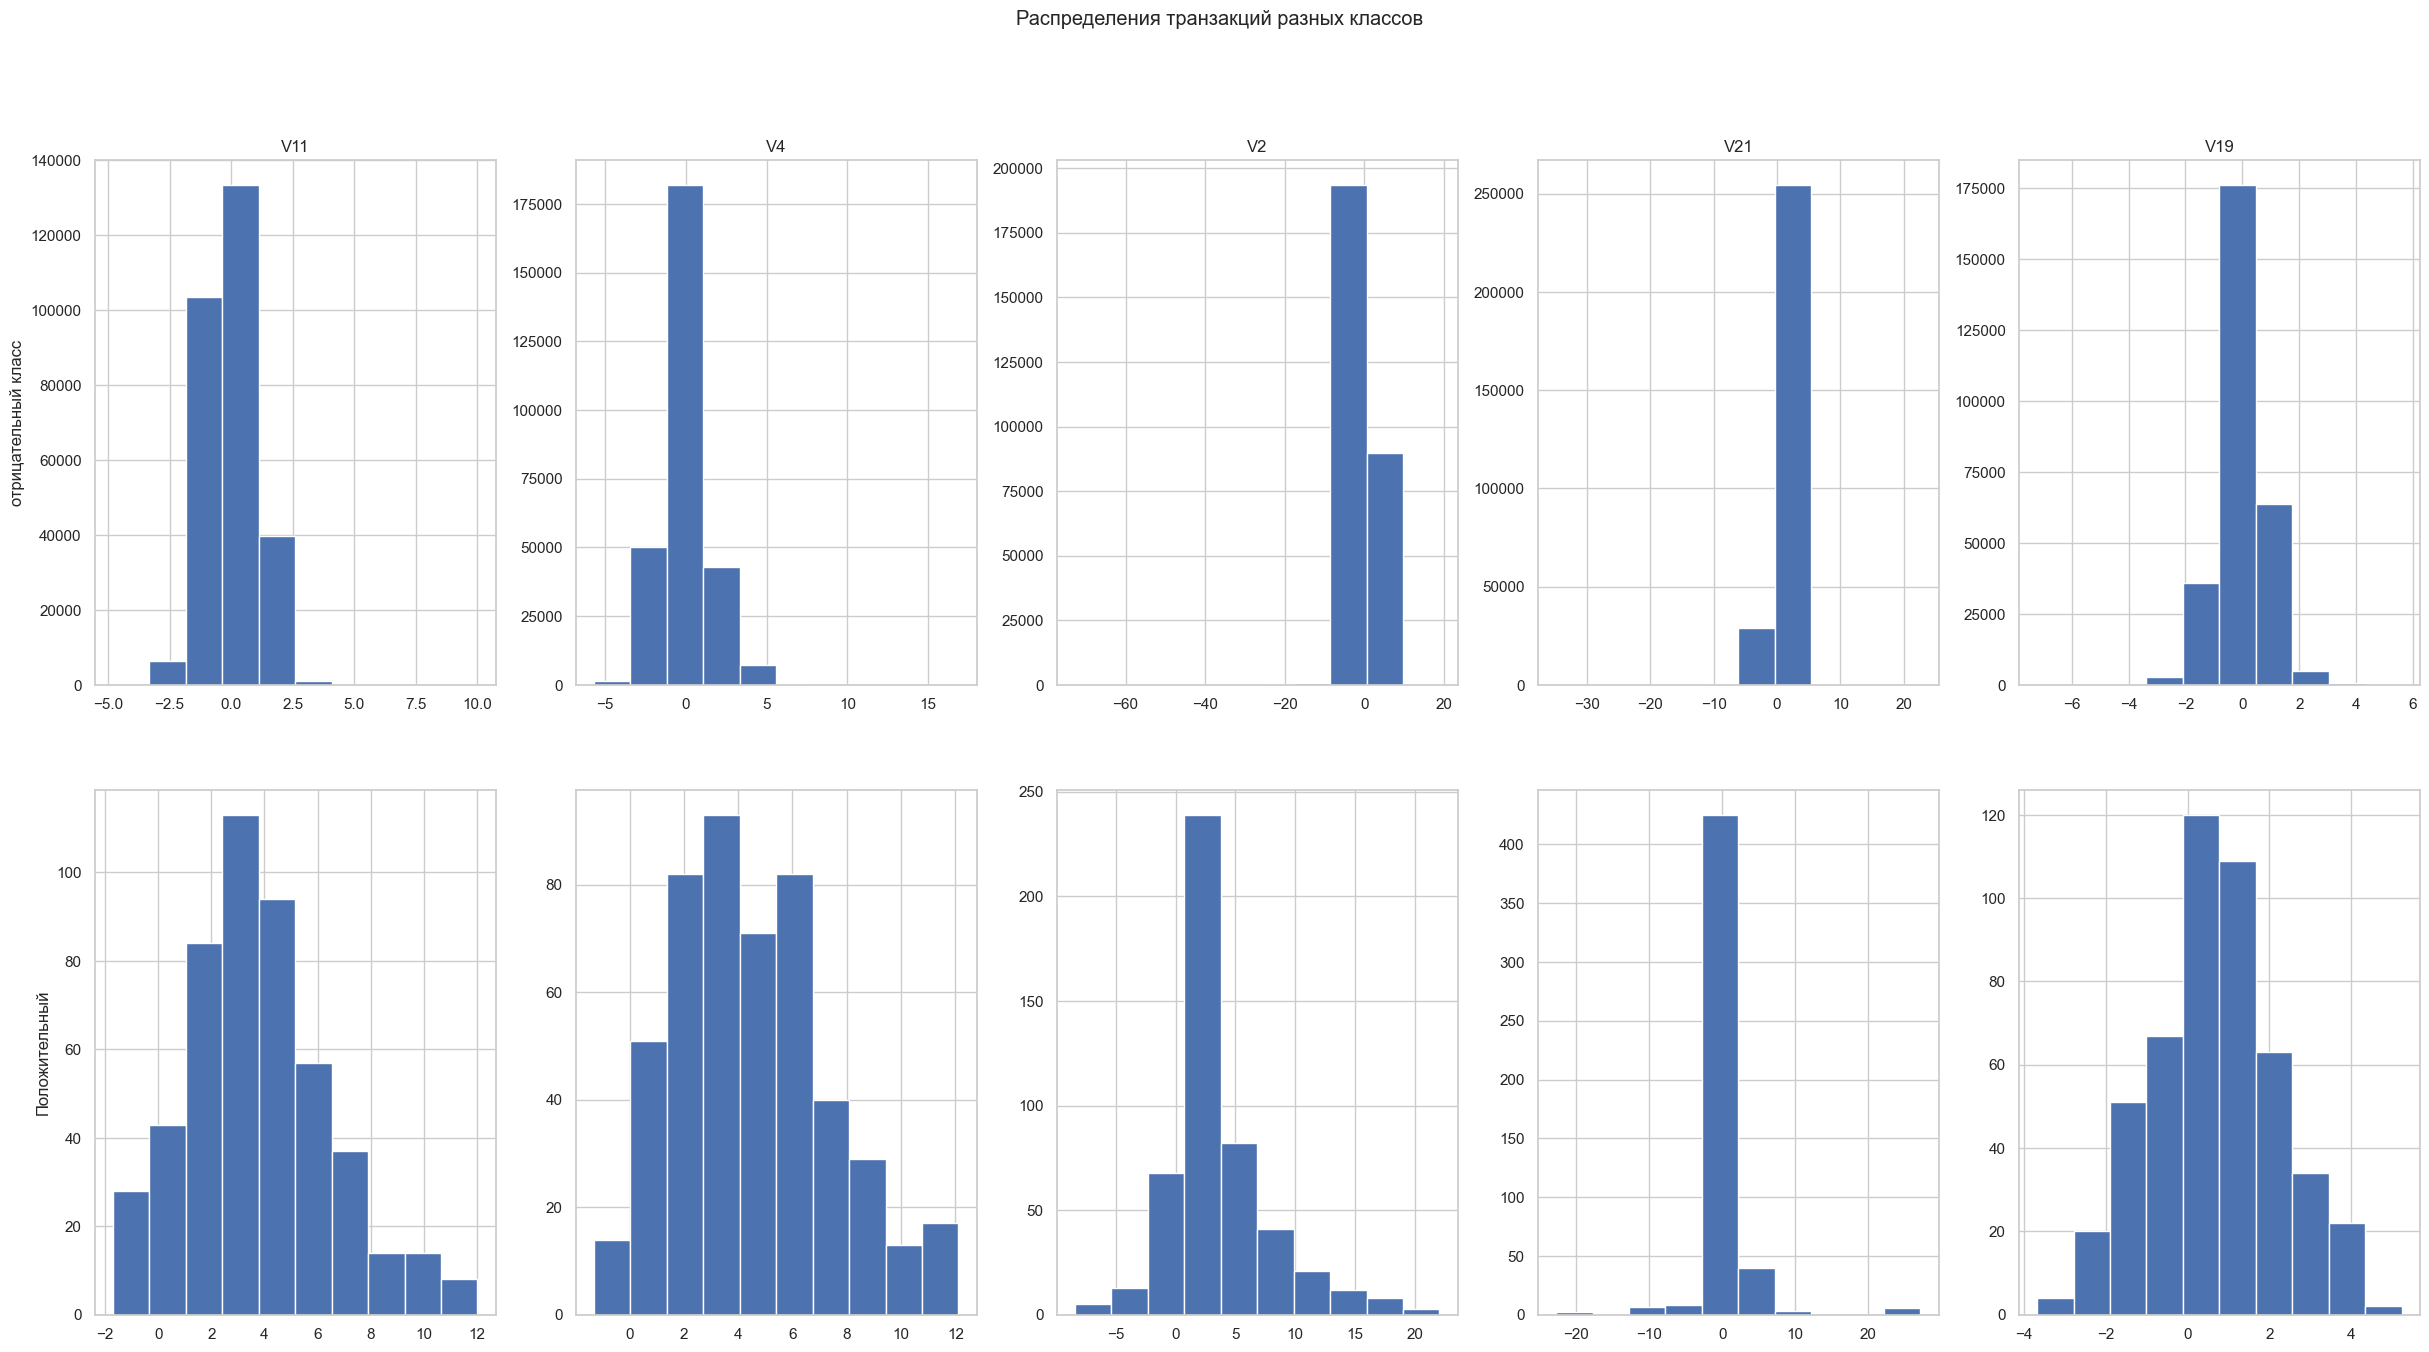

In [11]:
fig, ax = plt.subplots(2, 5) #Спросил у чата ГПТ как красиво сделать несколько графиков, с МО-1 забыл(
fig.set_size_inches(30, 15)

for i, it in enumerate(krut[1:]):
    ax[0][i].hist(df[df['Class'] == 0][it], bins=10)
    ax[1][i].hist(df[df['Class'] == 1][it], bins=10)
    ax[0][i].set_title(it)
fig.suptitle('Распределения транзакций разных классов')
ax[0][0].set_ylabel('отрицательный класс')
ax[1][0].set_ylabel('Положительный')
plt.show()

Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим. 

In [12]:
#your code here
DF = df.sort_values('Time')
df_test = df.loc[(df['Time']<(df.quantile(0.9)['Time'])) & (df['Time']>=(df.quantile(0.8)['Time']))]
df_valid = df.loc[df['Time']>=(df.quantile(0.9)['Time'])]
df = df.drop(df_test.index)
train = df.drop(df_valid.index)

# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога. 

In [13]:
#your code here
from sklearn.metrics import precision_recall_curve, auc

def calculate_auc_pr(y_true, y_scores):
    """
    Вычислить AUC-PR для предсказаний модели.

    :param y_true: Список истинных меток классов (0 и 1).
    :param y_scores: Список предсказанных вероятностей для положительного класса.
    :return: Значение AUC-PR.
    """
    # Вычисляем precision и recall для различных порогов
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    
    # Вычисляем AUC-PR
    auc_pr = auc(recall, precision)
    
    return auc_pr


Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

In [14]:
#your code here
import numpy as np

def kappa(y_true, y_pred):
    """
    Вычислить коэффициент Каппа Коэна для предсказаний модели.

    :param y_true: Список истинных меток классов (0 и 1).
    :param y_pred: Список предсказанных меток классов (0 и 1).
    :return: Значение коэффициента Каппа Коэна.
    """    
    # Вычисляем матрицу сопряженности(подсмотрел в сорсе документации)
    confusion_matrix = np.zeros((2, 2))
    for true, pred in zip(y_true, y_pred):
        confusion_matrix[true, pred] += 1

    # Сумма элементов в матрице (всего наблюдений)
    n = np.sum(confusion_matrix)
    
    p0 = (confusion_matrix[0, 0] + confusion_matrix[1, 1]) / n
    p_yes = (np.sum(confusion_matrix[1, :]) / n) * (np.sum(confusion_matrix[:, 1]) / n)
    p_no = (np.sum(confusion_matrix[0, :]) / n) * (np.sum(confusion_matrix[:, 0]) / n)
    pe = p_yes + p_no
    
    # Вычисляем Каппа Коэна
    kappa = (p0 - pe) / (1 - pe)
    
    return kappa

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом. 

In [15]:
#your code here

import numpy as np

def mcc(y_true, y_pred):
    """
    Вычислить коэффициент корреляции Мэтьюза для предсказаний модели.

    :param y_true: Список истинных меток классов (0 и 1).
    :param y_pred: Список предсказанных меток классов (0 и 1).
    :return: Значение коэффициента корреляции Мэтьюза.
    """
    # Вычисляем значения матрицы ошибок
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    # Вычисляем MCC
    numerator = TP * TN - FP * FN
    denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    
    if denominator == 0:
        return 0

    mcc = numerator / denominator
    return mcc


Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [16]:
#your code here
y_true = df['Class'] 
majority_class = np.argmax(np.bincount(y_true))
y_test_naive = np.full_like(df_test['Class'], majority_class)

print(f'AUC-PR получился такой: {round(calculate_auc_pr(df_test['Class'], y_test_naive), 5)}')
print(f'каппа-коуэн получился такой: {round(kappa(df_test['Class'], y_test_naive), 5)}')
print(f'Корреляция мэтьюза получилась такой: {round(mcc(df_test['Class'], y_test_naive), 5)}')

AUC-PR получился такой: 0.50093
каппа-коуэн получился такой: 0.0
Корреляция мэтьюза получилась такой: 0


Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`). 

In [17]:
from catboost import CatBoostClassifier

In [18]:
df_test.drop('Class', axis = 1)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,day,hour
227845,145248.0,1.914027,-0.490068,-0.326111,0.604711,-0.850136,-0.736319,-0.524058,-0.088614,1.091125,0.093484,-0.892305,0.027221,-0.243790,0.031774,0.900624,0.536032,-0.648408,0.183072,-0.486322,-0.139579,0.210958,0.639338,0.147523,0.073654,-0.318378,0.350612,-0.023843,-0.037139,50.00,1.0,16.0
227846,145249.0,2.152696,-0.036161,-2.231811,0.091766,0.537612,-1.368103,0.613327,-0.455252,0.291814,0.253161,-1.501882,-0.870608,-1.441738,0.988757,0.496349,-0.068699,-0.454073,-0.299095,0.267443,-0.275778,0.017153,0.063242,-0.034561,-0.626866,0.249213,0.773931,-0.137115,-0.090611,14.95,1.0,16.0
227847,145249.0,-4.034795,2.305079,-1.461693,-0.729887,-1.528750,-1.225679,-0.893354,1.622522,1.291998,-0.040956,-0.971425,0.574744,0.155656,-0.729055,0.477439,1.061719,0.934695,0.403769,-0.494930,-0.081093,-0.392557,-0.787599,0.343468,-0.090331,0.248287,-0.238524,0.266484,-0.062236,7.70,1.0,16.0
227848,145249.0,-1.668741,1.168055,0.249642,-1.268497,0.785923,-0.663959,0.859433,0.068111,-0.144183,0.043288,0.542014,1.002025,0.400760,0.136412,-1.289649,0.276828,-0.868492,-0.366840,-0.187392,-0.033523,-0.247544,-0.592537,-0.286694,-0.378856,-0.077429,0.067608,-0.278962,-0.064193,6.99,1.0,16.0
227849,145250.0,-0.550678,-0.429004,-1.291893,-0.414409,-0.292229,0.071843,2.426068,-0.212730,0.412374,-1.939969,-1.810118,-1.223510,-1.324915,-1.462392,-0.311641,0.506708,0.739933,0.892422,0.195043,0.791127,0.003032,-0.645783,0.877016,-1.228529,-0.036281,-0.110610,-0.098380,0.095985,460.71,1.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256321,157639.0,-1.994580,-1.635319,1.006695,-1.433183,3.259194,4.008239,-1.660020,1.099466,1.919685,-0.518544,-1.054712,0.446539,-0.468235,-1.404336,-1.810326,-0.277012,-0.290668,-0.608744,-0.218457,-0.677311,-0.258971,0.080971,-0.579908,0.830054,-0.462078,0.437226,-0.170401,0.017564,17.60,1.0,19.0
256322,157639.0,1.919950,-0.529575,-0.291774,0.644989,-0.766757,-0.384374,-0.616882,-0.030380,1.250724,0.013274,-1.100262,0.331735,0.193348,-0.257783,0.390829,0.283303,-0.504784,0.057998,-0.378146,-0.135899,0.239401,0.864998,0.078354,-0.109595,-0.197549,0.455488,-0.008264,-0.041418,41.94,1.0,19.0
256323,157639.0,-0.356158,1.191407,-0.437619,1.173899,0.525368,-0.471524,0.199218,0.239205,-0.757000,-0.433462,-0.626163,-0.170416,0.289081,-0.445257,1.382371,-0.697928,1.616873,0.214470,2.760773,0.149752,-0.182842,-0.552938,0.033595,0.614989,-0.986868,0.524162,-0.019874,0.100141,1.98,1.0,19.0
256324,157639.0,2.025835,-0.046070,-1.249393,0.274412,-0.027561,-1.099714,0.154687,-0.263755,0.335313,0.185335,1.082110,1.001305,-0.065447,0.695657,0.036425,-0.046127,-0.718075,0.403463,0.023068,-0.241082,0.302148,1.003410,-0.000059,0.113962,0.224938,-0.133709,-0.023353,-0.068055,0.89,1.0,19.0


In [19]:
#your code here
import os
X_train = train.drop('Class', axis = 1)
y_train = train['Class']

X_valid = df_valid.drop('Class', axis = 1)
y_valid = df_valid['Class']

X_test = df_test.drop('Class', axis = 1)
y_test = df_test['Class']

boost = CatBoostClassifier(random_seed=42)

train_dir = "catboost_info"
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

# Настройте и обучите модель
boost = CatBoostClassifier(random_seed=42, train_dir=train_dir)
boost.fit(X_train, y_train)


Learning rate set to 0.104628
0:	learn: 0.3572230	total: 155ms	remaining: 2m 34s
1:	learn: 0.1833873	total: 171ms	remaining: 1m 25s
2:	learn: 0.0949133	total: 189ms	remaining: 1m 2s
3:	learn: 0.0527124	total: 205ms	remaining: 51.1s
4:	learn: 0.0310216	total: 223ms	remaining: 44.3s
5:	learn: 0.0197164	total: 240ms	remaining: 39.7s
6:	learn: 0.0134723	total: 255ms	remaining: 36.2s
7:	learn: 0.0096814	total: 272ms	remaining: 33.7s
8:	learn: 0.0074001	total: 287ms	remaining: 31.6s
9:	learn: 0.0060125	total: 303ms	remaining: 30s
10:	learn: 0.0050823	total: 319ms	remaining: 28.7s
11:	learn: 0.0044552	total: 337ms	remaining: 27.7s
12:	learn: 0.0039390	total: 352ms	remaining: 26.7s
13:	learn: 0.0036010	total: 368ms	remaining: 25.9s
14:	learn: 0.0033192	total: 382ms	remaining: 25.1s
15:	learn: 0.0031508	total: 398ms	remaining: 24.5s
16:	learn: 0.0029660	total: 414ms	remaining: 23.9s
17:	learn: 0.0028584	total: 429ms	remaining: 23.4s
18:	learn: 0.0027950	total: 443ms	remaining: 22.9s
19:	learn: 

In [20]:
y_train_pred = boost.predict(X_train)
y_valid_pred = boost.predict(X_valid)
y_test_pred = boost.predict(X_test)

y_train_pred_proba = boost.predict_proba(X_train)[:, 1]
y_valid_pred_proba = boost.predict_proba(X_valid)[:, 1]
y_test_pred_proba = boost.predict_proba(X_test)[:, 1]

print(f"каппа-коуэн на обучении получился такой:  {kappa(y_train, y_train_pred)}")
print(f"Корреляция мэтьюза на обучении получилась такой: {mcc(y_train, y_train_pred)}")
print(f"AUC-PR на обучении получился такой: {calculate_auc_pr(y_train, y_train_pred_proba)}")

print(f"каппа-коуэн на валидации получился такой: {kappa(y_valid, y_valid_pred)}")
print(f"Корреляция мэтьюза на валидации получилась такой: {mcc(y_valid, y_valid_pred)}")
print(f"AUC-PR на валидации получился такой: {calculate_auc_pr(y_valid, y_valid_pred_proba)}")

print(f"каппа-коуэн на валидации получился такой: {kappa(y_test, y_test_pred)}")
print(f"Корреляция мэтьюза на валидации получилась такой: {mcc(y_valid, y_valid_pred)}")
print(f"AUC-PR на валидации получился такой: {calculate_auc_pr(y_valid, y_valid_pred_proba)}")

каппа-коуэн на обучении получился такой:  1.0
Корреляция мэтьюза на обучении получилась такой: 1.0
AUC-PR на обучении получился такой: 1.0
каппа-коуэн на валидации получился такой: 0.7498260790128308
Корреляция мэтьюза на валидации получилась такой: 0.7536088618289372
AUC-PR на валидации получился такой: 0.6903594693128843
каппа-коуэн на валидации получился такой: 0.8128960256099498
Корреляция мэтьюза на валидации получилась такой: 0.7536088618289372
AUC-PR на валидации получился такой: 0.6903594693128843


Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [21]:
#your code here
w = round(len(train)/len(train[train['Class'] == 1]), 0)
boost = CatBoostClassifier(class_weights = [1, int(w)], random_seed = 777)
boost.fit(X_train, y_train)

Learning rate set to 0.104628
0:	learn: 0.5247828	total: 18.4ms	remaining: 18.4s
1:	learn: 0.4240117	total: 35.7ms	remaining: 17.8s
2:	learn: 0.3446321	total: 51.6ms	remaining: 17.1s
3:	learn: 0.2766006	total: 66.6ms	remaining: 16.6s
4:	learn: 0.2328677	total: 84.5ms	remaining: 16.8s
5:	learn: 0.2133225	total: 102ms	remaining: 16.8s
6:	learn: 0.1875155	total: 119ms	remaining: 16.9s
7:	learn: 0.1619535	total: 136ms	remaining: 16.9s
8:	learn: 0.1501429	total: 152ms	remaining: 16.8s
9:	learn: 0.1351400	total: 169ms	remaining: 16.7s
10:	learn: 0.1235587	total: 185ms	remaining: 16.7s
11:	learn: 0.1164583	total: 201ms	remaining: 16.5s
12:	learn: 0.1081257	total: 217ms	remaining: 16.5s
13:	learn: 0.0978894	total: 233ms	remaining: 16.4s
14:	learn: 0.0930241	total: 248ms	remaining: 16.3s
15:	learn: 0.0879881	total: 266ms	remaining: 16.3s
16:	learn: 0.0839764	total: 283ms	remaining: 16.4s
17:	learn: 0.0812630	total: 299ms	remaining: 16.3s
18:	learn: 0.0764011	total: 317ms	remaining: 16.3s
19:	le

In [22]:
y_train_pred = boost.predict(X_train)
y_valid_pred = boost.predict(X_valid)
y_test_pred = boost.predict(X_test)

y_train_pred_proba = boost.predict_proba(X_train)[:, 1]
y_valid_pred_proba = boost.predict_proba(X_valid)[:, 1]
y_test_pred_proba = boost.predict_proba(X_test)[:, 1]

print(f"каппа-коуэн на обучении получился такой:  {kappa(y_train, y_train_pred)}")
print(f"Корреляция мэтьюза на обучении получилась такой: {mcc(y_train, y_train_pred)}")
print(f"AUC-PR на обучении получился такой: {calculate_auc_pr(y_train, y_train_pred_proba)}")

print(f"каппа-коуэн на валидации получился такой: {kappa(y_valid, y_valid_pred)}")
print(f"Корреляция мэтьюза на валидации получилась такой: {mcc(y_valid, y_valid_pred)}")
print(f"AUC-PR на валидации получился такой: {calculate_auc_pr(y_valid, y_valid_pred_proba)}")

print(f"каппа-коуэн на валидации получился такой: {kappa(y_test, y_test_pred)}")
print(f"Корреляция мэтьюза на валидации получилась такой: {mcc(y_valid, y_valid_pred)}")
print(f"AUC-PR на валидации получился такой: {calculate_auc_pr(y_valid, y_valid_pred_proba)}") #ОНЕЕЕЕЕТ ВСЁ СЛОМАЛОСЬ КАК И ГОВОРЯТ В ЗАДАНИИ((

каппа-коуэн на обучении получился такой:  0.954145646524139
Корреляция мэтьюза на обучении получилась такой: 0.955150334847941
AUC-PR на обучении получился такой: 0.9972846020364865
каппа-коуэн на валидации получился такой: 0.6954066627452857
Корреляция мэтьюза на валидации получилась такой: 0.6960659441542087
AUC-PR на валидации получился такой: 0.7295009453736357
каппа-коуэн на валидации получился такой: 0.8450993167857853
Корреляция мэтьюза на валидации получилась такой: 0.6960659441542087
AUC-PR на валидации получился такой: 0.7295009453736357


Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части. 

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

In [23]:
#your code here


for w in tqdm(np.linspace(100, 1500, 15)):
    boost = CatBoostClassifier(class_weights=[1, w], random_seed = 777)
    boost.fit(X_train, y_train, verbose=False)

    y_valid_pred = boost.predict(X_valid)
    y_valid_pred_proba = boost.predict_proba(X_valid)[:, 1]

    print(f'вес: {w}')
    print(f"каппа-коуэн на валидации получился такой: {kappa(y_valid, y_valid_pred)}")
    print(f"Корреляция мэтьюза на валидации получилась такой:  {mcc(y_valid, y_valid_pred)}")
    print(f"AUC-PR на валидации получился такой: {calculate_auc_pr(y_valid, y_valid_pred_proba)}")

  0%|          | 0/15 [00:00<?, ?it/s]

вес: 100.0
каппа-коуэн на валидации получился такой: 0.6954066627452857
Корреляция мэтьюза на валидации получилась такой:  0.6960659441542087
AUC-PR на валидации получился такой: 0.7330495336197146
вес: 200.0
каппа-коуэн на валидации получился такой: 0.7270618976582063
Корреляция мэтьюза на валидации получилась такой:  0.7270618976581941
AUC-PR на валидации получился такой: 0.7213646115417924
вес: 300.0
каппа-коуэн на валидации получился такой: 0.7270618976582063
Корреляция мэтьюза на валидации получилась такой:  0.7270618976581941
AUC-PR на валидации получился такой: 0.7220941297253958
вес: 400.0
каппа-коуэн на валидации получился такой: 0.6663874946556728
Корреляция мэтьюза на валидации получилась такой:  0.6687173797351023
AUC-PR на валидации получился такой: 0.696515318255477
вес: 500.0
каппа-коуэн на валидации получился такой: 0.6954066627452857
Корреляция мэтьюза на валидации получилась такой:  0.6960659441542087
AUC-PR на валидации получился такой: 0.705143690127859
вес: 600.0
к

In [ ]:
#Лучшим весом получилось 100

In [ ]:
boost= CatBoostClassifier(class_weights = [1, 100], random_seed = 777)

In [ ]:
for p in tqdm(np.linspace(0.45, 0.75, 10)):#По-честному спросил какие пороги норм перебрать.
    y_valid_pred = (y_valid_pred_proba >= p).astype(int)
    print(f"порог: {p}")
    print(f"каппа-коуэн на валидации получился такой: {kappa(y_valid, y_valid_pred)}")
    print(f"Корреляция мэтьюза на валидации получилась такой: {mcc(y_valid, y_valid_pred)}")
    print(f"AUC-PR на валидации получился такой:  {calculate_auc_pr(y_valid, y_valid_pred_proba)}") #Анлак, что не успеваю
    print('___skip___')

  0%|          | 0/10 [00:00<?, ?it/s]

порог: 0.45
каппа-коуэн на валидации получился такой: 0.6271234207633684
Корреляция мэтьюза на валидации получилась такой: 0.6331260698053061
AUC-PR на валидации получился такой:  0.7000921986569126
___skip___
порог: 0.48333333333333334
каппа-коуэн на валидации получился такой: 0.6271234207633684
Корреляция мэтьюза на валидации получилась такой: 0.6331260698053061
AUC-PR на валидации получился такой:  0.7000921986569126
___skip___
порог: 0.5166666666666667
каппа-коуэн на валидации получился такой: 0.6271234207633684
Корреляция мэтьюза на валидации получилась такой: 0.6331260698053061
AUC-PR на валидации получился такой:  0.7000921986569126
___skip___
порог: 0.55
каппа-коуэн на валидации получился такой: 0.6271234207633684
Корреляция мэтьюза на валидации получилась такой: 0.6331260698053061
AUC-PR на валидации получился такой:  0.7000921986569126
___skip___
порог: 0.5833333333333334
каппа-коуэн на валидации получился такой: 0.6396882805812039
Корреляция мэтьюза на валидации получилась т

**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса. 

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

In [ ]:
!pip3 install imbalanced-learn

   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/258.0 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/258.0 kB 325.1 kB/s eta 0:00:01
   ------ -------------------------------- 41.0/258.0 kB 279.3 kB/s eta 0:00:01
   ---------- ---------------------------- 71.7/258.0 kB 435.7 kB/s eta 0:00:01
   ------------------ ------------------- 122.9/258.0 kB 599.1 kB/s eta 0:00:01
   ---------------------------- --------- 194.6/258.0 kB 784.3 kB/s eta 0:00:01
   -------------------------------------  256.0/258.0 kB 923.9 kB/s eta 0:00:01
   -------------------------------------- 258.0/258.0 kB 878.5 kB/s eta 0:00:00


Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку. 

In [ ]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).

In [ ]:
#your code here
sm = SMOTE()
X_train_new, y_train_new = sm.fit_resample(X_train, y_train)

cb = CatBoostClassifier(random_seed=42, verbose=False)

cb.fit(X_train_new, y_train_new)

y_val_pred_proba = cb.predict_proba(X_valid)[:, 1]
y_test_pred = cb.predict(X_test)
print(f"каппа-коуэн на валидации получился такой: {kappa(y_valid, y_valid_pred)}")
print(f"Корреляция мэтьюза на валидации получилась такой: {mcc(y_valid, y_valid_pred)}")
print(f"AUC-PR на валидации получился такой:  {calculate_auc_pr(y_valid, y_valid_pred_proba)}") 

каппа-коуэн на валидации получился такой: 0.652765635791055
Корреляция мэтьюза на валидации получилась такой: 0.6561966972262978
AUC-PR на валидации получился такой:  0.7000921986569126


**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это смог понять):

BorderlineSMOTE - Этот метод основан на оверсемплинге объектов минорного класса, которые находятся вблизи границы между классами. Для определения граничных объектов используется простой алгоритм: выбираются K ближайших соседей для каждого объекта, и если среди них значительное количество как мажорных, так и минорных объектов, то такой объект считается граничным. Далее для граничных объектов применяется классический SMOTE.

SVM-SMOTE - Метод SVM-SMOTE похож на BorderlineSMOTE, но вместо K ближайших соседей для определения граничных объектов используется метод опорных векторов (SVM). Здесь также происходит оверсемплинг, но только для тех объектов, которые являются опорными векторами, что позволяет точнее учитывать границу разделения классов.

K-Means-SMOTE - Метод K-Means-SMOTE основан на использовании кластеризации. Сначала данные разбиваются на кластеры с помощью K-means, затем внутри каждого кластера оценивается соотношение минорных и мажорных объектов. В тех кластерах, где минорных объектов больше, чем мажорных, применяется SMOTE для оверсемплинга новых объектов до достижения необходимого баланса классов.

ADASYN - Эта штука основана на генерации дополнительных объектов минорного класса пропорционально количеству соседей из мажорного класса. Чем больше соседей из мажорного класса имеет объект минорного класса, тем больше новых объектов будет сгенерировано вокруг него.

Теперь попробуйте сравнить качество всех методов на наших данных.

In [ ]:
#your code here

**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
#your code here

Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [ ]:
from imblearn.under_sampling import NearMiss

#your code here

**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.

**Бонус (2 балла)**. Сможете ли вы с помощью комбинации любых методов оверсэмплинга, андерсэмплинга и классификации набрать 0.8 на всех трех метриках?

# Часть 2. Поиск аномалий. 

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка. 

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных). 

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову). 

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.



**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


In [ ]:
def c_factor(n):
    """
    Computes average path length for an unsuccessful search in a binary search tree.
    Params:
        n: int - number of data points for BST
    """
    #your code here

def calc_height(X, depth, node):
    """
    Calculates anomaly scores for sample in a recursive manner.
    Params:
        X: np.array - current sample, available to node
        
        depth: int - path length up to current node
        
        node: Node - current tree node
        
    Returns:
        scores: int, float or np.array - anomaly scores for sample
    """
    scores = np.zeros(X.shape[0])

    #your code here


class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.
    
    Attributes:
        X: np.array - data available to current node
        size: int - length of available data
        
        depth: int - depth of node

        left: Node - left child
        right: Node - right child

        kind: str - either "internal" or "external", indicates the type of current node

        w: np.array - normal vector for the splitting hyperplane
        b: float - intercept term for the splitting hyperplane
    """
    def __init__(self, X, depth, left, right, kind, w, b):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.
        
        Params:
            X: np.array - data available to current node
            depth: int - depth of node
            
            left: Node - left child
            right: Node - right child
            
            kind: str - either "internal" or "external", indicates the type of current node
            
            w: np.array - normal vector for the splitting hyperplane
            b: float - intercept term for the splitting hyperplane
            
        """
        self.size = len(X)
        
        self.depth = depth
        
        self.left = left
        self.right = right
        
        self.kind = kind
    
        self.w = w
        self.b = b
    
    def __repr__(self):
        """
        For convenience only.
        """
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"

class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).
    Attributes:
        depth: int - current tree depth
        
        max_depth: int - maximum tree depth
        
        root: Node - root node 

        internal_count: int - number of internal nodes

        external_count: int - number of external nodes
        
    """
    def __init__(self, X, max_depth):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).
        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth

        """
        self.depth = 0
        self.max_depth = max_depth
        
        self.internal_count = 0
        self.external_count = 0

        self.root = self.grow(X, 0)
        
    def __repr__(self):
        """
        For convenience only.
        """
        
        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"

        
        
    def grow(self, X, depth):
        """
        Grow tree in a recursive manner.
        Params:
            X: np.array - available train sample
            
            depth: int - current tree depth
            
        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """
        #your code here
            
        return Node(X, depth, left, right, kind, w, b)

    def score_samples(self, X):
        """
        Calculate anomaly scores for given data. You may utilize outer function `calc_height`.
        Params:
            X: np.array - data to be evaluated
            
        Returns:
            scores: np.array - estimated anomaly scores
        """
        #your code here

        return scores
        
    
class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.
    Attributes:
        n_trees: int - number of Randomized Trees
        
        max_depth: int - maximum depth of each tree
        
        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree
        
        trees: list - container for trained trees 
        
        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding
        
    """
    
    def __init__(self, n_trees, subsample_rate, max_depth=None, contamination=0.01):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.
        Params:
            n_trees: int - number of Randomized Trees

            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided

            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.trees = []
        self.contamination = contamination
        self.is_fit = False
        
    def __repr__(self):
        """For convenience only."""
        
        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"
        
    def fit(self, X):
        """
        Fit EIF to new data.
        Params:
            X: np.array - 2d array of samples
        """
        #your code here
        return self
    
    def score_samples(self, X):
        """
        Estimate (normalized) anomaly score for each given sample
        Params:
            X: np.array - new samples

        Returns:
            scores: np.array - anomaly scores (larger value means higher probability of a sample being an outlier)
        """
        #your code here

        return scores

    
    def predict(self, X):
        """
        Predict if given samples are outliers.
        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """
        #your code here

        return labels


**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

In [ ]:
#your code here

Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

In [ ]:
#your code here

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

In [ ]:
#your code here

У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

In [ ]:
#your code here

**Бонус. (0.1 балла).**

При сдаче проверяющий запустит следующую клетку один раз. Если она даст положительный результат, вы получите 0.1 бонусных балла. Если она даст отрицательный результат, вы получите -0.1 бонусных балла. 

Если вы хотите отказаться от сдачи данного задания, допишите "хочу" после двоеточия: `your text here`

Ниже вы можете попрактиковаться и оценить ваши силы (изменять код ячейки запрещается!)

In [145]:
import random

rng = random.SystemRandom(0)
rng.uniform(-1.0, 1.0)

0.6542800924834957

Я РИСКОФИИИИИИИИИИИЛ